# Disentanglement in VAEs with the Spatial Broadcast Decoder

</br></br>
<div align="center">
<img src='img/shells.png'>
</div>
</br></br>


The world around us is noisy and constantly changing, yet our brain manages to filter out irrelevant details, and learn what we need. Think of sea shells, for example. If you weren't born close to the sea, you probably learned first about them in school, or you saw them in a movie, or in a photograph. Then, when going for the first time to the beach, you could pick one of them and recognize as such: an actual sea shell in your hands, that you identified while living a totally new experience. How is this possible? And, more importantly, can we give machines this ability as well?

This is a fundamental issue in artificial intelligence, and in deep learning it is known as the problem of *representation learning*: we want to build machines that sense the world, and extract from observations a "good" representation of them. But what makes a representation *good*? A digital image can contain millions of pixels, that altogether resemble a scene almost perfectly. However, devising a simple rule that maps all that million of values to a single number, that determines whether the image contains a sea shell or not, is hard. Even if we can find that rule, we won't probably be able to guarantee that it will work for a new image, under new lighting conditions and textures, where all the pixels are extremely different. We need to **compress** the input first, that discards noise in the observation.

One way to learn compressed representations is to use a <a href="https://dfdazac.github.io/01-vae.html" target="_blank">Variational Autoencoder</a> (VAE). Given an observation $\mathbf{x}$, the VAE learns a mapping to a code $\mathbf{z}$ that lies in a space of lower dimension, with enough information that can be used to reconstruct $\mathbf{x}$. The VAE is a very interesting model that has generated a large amount of related work, including research in **disentangled representations**. Even though there is no precise definition, we can think of disentanglement as requiring each element in $\mathbf{z}$ to represent exactly each factor of variation in the observation. Factors of variation can include horizontal and vertical position, shape, color, and rotation. In <a href="https://towardsdatascience.com/what-a-disentangled-net-we-weave-representation-learning-in-vaes-pt-1-9e5dbc205bd1">her article</a>, Cody Wild does an amazing job at explaining this in detail, together with how this can be achieved with VAEs.

In this post, we are going to examine the <a href="https://arxiv.org/abs/1901.07017">Spatial Broadcast Decoder</a> (SBD), an architecture proposed by scientists at DeepMind that seeks to improve disentanglement in representations learned by VAEs. We will use PyTorch to reproduce some of their experiments and evaluate the properties of the learned representations.

## The Spatial Broadcast Decoder

In the usual architecture, a VAE uses the encoder to give the parameters of the distribution of the code $\mathbf{z}$. A sample is then passed to the encoder to reconstruct the observation:

<div align="center">
<img src='img/vae.png'></br></br>
</div>

Many architectures that require generating an image from a low dimensional representation usually employ a deconvolution, or transposed convolution. In addition to the <a href="https://distill.pub/2016/deconv-checkerboard/" target="_blank">checkerboard artifacts</a> that this layer can generate, the authors of SBD argue that its use in VAEs increases the difficulty for the model to leverage spatial information. They propose to use an architecture in the decoder that introduces an inductive bias for spatial information that can be used when generating an image.

The architecture of the SBD consists of first taking $\mathbf{z}$ and tiling it to match the dimensions of the input image. Then, two matrices of horizontal and vertical coordinates are generated with the same dimensions. These coordinates are independent of the input image, and are arbitrarily chosen to cover the interval between -1 and 1. The two matrices are later concatenated to the tiled $\mathbf{z}$, which results in a 3D volume that can be passed to convolutional layers in the decoder:

<div align="center">
<img src='img/sbd.png'></br></br>
</div>

Instead of using a single version of $\mathbf{z}$ to figure out how to reconstruct the image, the SBD is given multiple versions, each attached to a specific location, in the form of a 3D volume that has the same spatial dimensions as the image to be reconstructed. By using padding, the decoder can keep these spatial dimensions constant and just reduce the number of channels. This eases the reconstruction task, and as we will see, it helps the VAE to learn disentangled representations.

## Testing the SBD

To better examine the properties of the representations learned by the VAE, we can use synthetic datasets where the factors of variation are known in advance. We are going to use a similar dataset as that used by the authors of SBD, where each image contains a circle and two factor of variations: horizontal and vertical position:

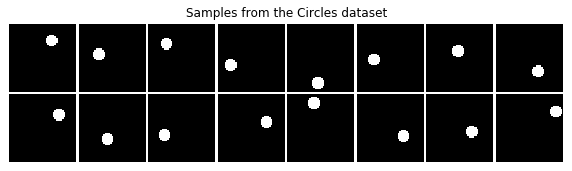

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader

import sys, os
sys.path.append(os.getcwd() + os.sep + os.pardir)
from utils import plot_examples

# Load tensors with the dataset
train_file = '../data/circles/data.pt'
dataset = TensorDataset(torch.load(train_file))
loader = DataLoader(dataset, batch_size=128, shuffle=True)

# Show 16 samples
x = next(iter(loader))[0][:16]
plt.figure(figsize=(10, 4))
plot_examples(x, 'Samples from the Circles dataset')

In the repository accompanying this post, I have provided an implementation of the SBD together with a training script. For this post, we will work with a pretrained model.

In [2]:
from models import VAE

torch.set_grad_enabled(False)
model = VAE(im_size=64)
model.load_state_dict(torch.load('vae_circles.pt', map_location='cpu'));

An interesting first experiment is to check the reconstructions provided by the decoder. For this, we will pass 16 samples of the dataset to the encoder, which will return the parameters of the posterior distribution of the code $\mathbf{z}$. We will then use the mean to obtain a reconstruction using the decoder:

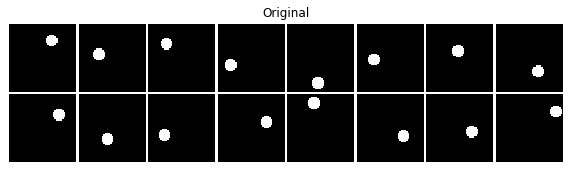

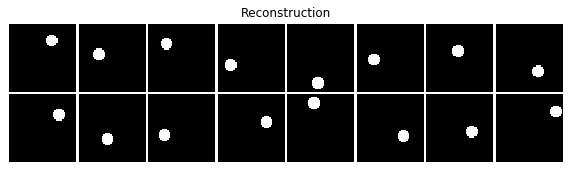

In [3]:
mean, logvar = model.encoder(x)
reconstruction = model.decoder(mean)

plt.figure(figsize=(10, 4))
plot_examples(x, 'Original')

plt.figure(figsize=(10, 4))
plot_examples(reconstruction, 'Reconstruction')

We can see that the reconstructions are fairly good. We can also see this when following a linear interpolation between two codes of different observations:

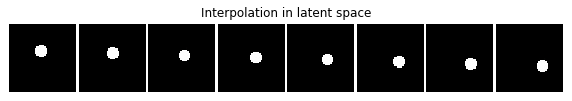

In [4]:
# Select two arbitrary codes
mu1 = mean[6:7]
mu2 = mean[13:14]

# Interpolate using 8 steps, from one code to the other
c = torch.linspace(0, 1, steps=8).unsqueeze(dim=1)
interp = mu2 * c + mu1 * (1 - c)
plt.figure(figsize=(10, 4))

# Decode the interpolations
plot_examples(model.decoder(interp), 'Interpolation in latent space')

### Measuring variance in the latent space

Let's recall the loss function that is used to train the VAE:

$$
\begin{equation}
\mathcal{L} = \mathbb{E}_{q(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})}[p(\mathbf{x}\vert\mathbf{z},\boldsymbol{\theta}] - \text{KL}[q(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})\Vert p(\mathbf{z})]
\end{equation}
$$

An interesting observation from this loss comes from the KL divergence term, which penalizes the model every time the posterior distribution $p(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})$ deviates from the prior $p(\mathbf{z})$. This prior is often chosen as a standard normal, with zero mean and identity covariance matrix, which has some important consequences:

- If the covariance of the posterior $q(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})$ is the identity for *all* observations $\mathbf{x}$, the KL divergence penalty will decrease. However, this means that the decoder will have a harder time to reconstruct the observations, since all the codes have high variance and they are likely to overlap in the latent space.
- To make the task easier for the decoder, the model can reduce the variance of the posterior, so that different observations are easier to distinguish in the latent space. But this deviates from a standard normal, which will increase the reconstruction error.

If we put more emphasis on the KL divergence term, the model will tend to use the components of the latent code sparingly: when possible, the variance will be close to a standard normal, and only when it significantly helps towards better reconstructions, it will reduce the variance. The end effect is that **the representations will better discover the underlying factors of variation in the observations**, which is what we seek in disentangled representations. This is what is proposed in the <a href="https://openreview.net/forum?id=Sy2fzU9gl">$\beta$-VAE</a>, and is also clearly illustrated in <a href="https://towardsdatascience.com/what-a-disentangled-net-we-weave-representation-learning-in-vaes-pt-1-9e5dbc205bd1?gi=ea1863a2352e">Marie Cody's article</a> on VAEs.

The authors of SBD thus propose to use the components in the latent space with the lowest variance as the most informative according to the VAE. Here we will iterate through the Circles dataset, encoding the images and storing the log-variance provided by the encoder. Our VAE has a latent space with a dimension of 10, so we will draw a bar chart with the variance per axis, averaged across the dataset.

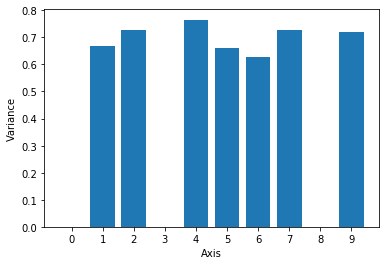

In [5]:
def get_avg_variance(model):
    avg_var = torch.zeros(10)
    for i, batch in enumerate(loader):
        x = batch[0]
        mean, logvar = model.encoder(x)
        avg_var += torch.mean(logvar.exp(), dim=0)/len(loader)

    plt.bar(range(avg_var.shape[0]), avg_var)
    plt.xticks(range(avg_var.shape[0]))
    plt.xlabel('Axis')
    plt.ylabel('Variance')
    
    return avg_var
    
avg_var = get_avg_variance(model)

Clearly, only a few of the components have a substantially lower variance, compared to the rest. We can now sort the latent dimensions by variance and select two with lowest values. Hopefully, they will correspond to the two factors of variation in the Circles dataset, that is, horizontal and vertical position.

In [6]:
def get_smallest_pair(tensor):
    sorted_latents = sorted(range(avg_var.shape[0]), key=lambda x: avg_var[x])
    x_latent, y_latent, *_ = sorted_latents
    return x_latent, y_latent

x_latent, y_latent = get_smallest_pair(avg_var)
print(f'Axes with lowest variance: {x_latent:d} and {y_latent:d}')

Axes with lowest variance: 0 and 3


The authors of SBD also propose an insightful method to evaluate disentanglement in VAEs. The idea can be applied when there are known factors of variation in the data. We will apply it here as follows:

- The factors of variation in the Circles dataset are horizontal ($x$) and vertical ($y$) position. We will first generate a grid of coordinates covering most of the space in the observed images.
- For each coordinate (x, y), synthesize an observation, with a circle positioned in that location.
- Pass the observation to the encoder, and store the two components of the mean given by the decoder, corresponding to the two axes with the lowest variance. These are coordinates $z_1$ and $z_2$ in the latent space.

Ideally, if the latent code has captured well the factors of variation, we hope that the geometry of the latent space resembles this. This way, a scatter plot with the grid of coordinates ($x$, $y$) would look very similar to a scatter plot with the coordinates ($z_1$, $z_2$) in the latent space.

We start by generating the grid of coordinates for the positions of the circles:

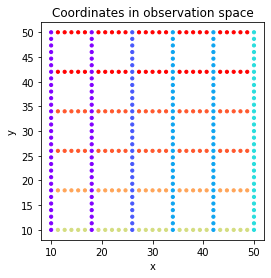

In [7]:
from utils import generate_spaced_coordinates

xx, yy, labels = generate_spaced_coordinates(low=10, high=50, num_points=31, levels=5)
plt.figure(figsize=(4, 4))
plt.scatter(xx, yy, c=labels, s=10, cmap=plt.cm.get_cmap('rainbow', 10))
plt.xlabel('x')
plt.ylabel('y');
plt.title('Coordinates in observation space');

We will then sinthesize a circle for each coordinate, and store the values of the latent components with the lowest variance of the encoded posterior:

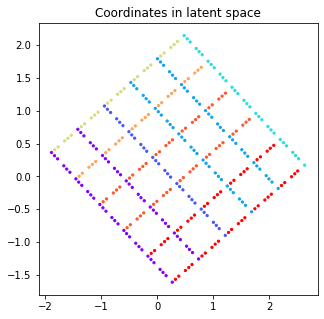

In [8]:
from data.data import Sprite, draw_sprites

def encode_coordinates(model, x, y, x_latent, y_latent):
    img_size=64
    num_samples = len(x)
    samples = torch.empty([num_samples, 3, img_size, img_size],
                           dtype=torch.float32)
    z1 = []
    z2 = []
    for i, s in enumerate(samples):
        # Sinthesize image at given coordinate
        sprites = [Sprite('ellipse', x[i], y[i], size=10, color=(255, 255, 255))]
        img = draw_sprites(sprites, img_size, bg_color=(0, 0, 0)).unsqueeze(dim=0)

        # Encode
        mu, logvar = model.encoder(img)
        z = mu.squeeze()

        # Store components with lowest variance
        z1.append(z[x_latent].item())
        z2.append(z[y_latent].item())

    return z1, z2

z1, z2 = encode_coordinates(model, xx, yy, x_latent, y_latent)
plt.figure(figsize=(5, 5))
plt.scatter(z1, z2, c=labels, s=5,  cmap=plt.cm.get_cmap('rainbow', 10))
plt.title('Coordinates in latent space');

It seems that the VAE is effectively encoding positional information in these two axes, and preserves the geometry up to a rotation in the latent space. In addition to the analysis of variance of each component, this visualization is a clear way to evaluate if there is any distortion in the latent space.

Since the SBD was introduced to improve disentanglement in VAEs, we may ask now, **how does it compare to a deconvolutional decoder?** Let's load a pretrained VAE with this type of decoder and repeat the analysis.

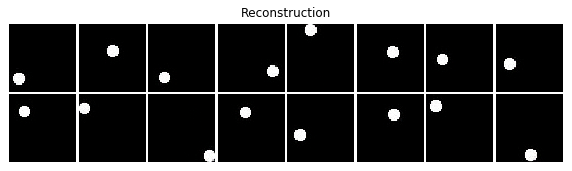

In [9]:
model = VAE(im_size=64, decoder='deconv')
model.load_state_dict(torch.load('vae_deconv_circles.pt', map_location='cpu'));

# Plot some reconstructions
x = next(iter(loader))[0][:16]
mean, _ = model.encoder(x)
plt.figure(figsize=(10, 4))
plot_examples(model.decoder(mean), 'Reconstruction')

The reconstructions seem to look fine, but let's now examine the properties of the representations learned by this VAE. We can first evaluate the average variance across components of the latent space:

Axes with lowest variance: 4 and 5


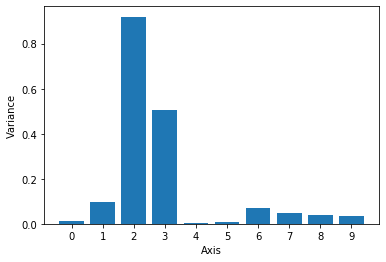

In [10]:
avg_var = get_avg_variance(model)
x_latent, y_latent = get_smallest_pair(avg_var)
print(f'Axes with lowest variance: {x_latent:d} and {y_latent:d}')

In this model it's less clear which dimensions could correspond to actual factors of variation, which indicates entanglement in the representation. Therefore, even though we have selected the axes with the lowest variance, it is unlikely that these correspond directly to the horizontal and vertical position of the circle. We can verify this by plotting coordinates in the latent space as before:

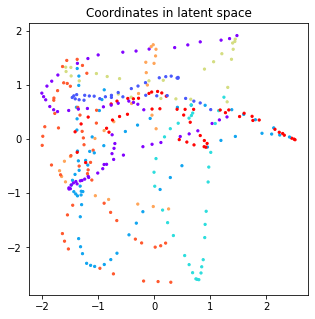

In [11]:
z1, z2 = encode_coordinates(model, xx, yy, x_latent, y_latent)
plt.figure(figsize=(5, 5))
plt.scatter(z1, z2, c=labels, s=5,  cmap=plt.cm.get_cmap('rainbow', 10))
plt.title('Coordinates in latent space');

The difference with SBD is quite dramatic, as we observe that simple changes in the position of the circle produce much more complex variations in the latent space.

These results show that the introduction of the SBD as an inductive bias for image reconstruction successfully enables the VAE to learn disentangled representations compared to a deconvolutional decoder. Recent works show promising results with SBD when applied to object representation learning, such as <a href="https://arxiv.org/abs/1901.11390">MONET</a> and <a href="https://arxiv.org/abs/1903.00450">IODINE</a>, which I would like to discuss in a future post.